# Begining of Life

The purpose of this notebook is to establish basic beginning of life parameters of this concept including $k_{eff}$ and neutron energy spectrum.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3206e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.8230e-4)
fuel.add_nuclide('U238',1.1363e-3)
fuel.add_element('C',7.5500e-2)
fuel.add_element('O',2.8371e-3)
fuel.add_element('S',3.4500e-3)
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.1

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = coolant
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

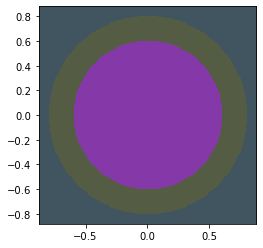

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      140/1    1.02125    1.03023 +/- 0.00084
      141/1    1.02671    1.03019 +/- 0.00083
      142/1    1.02592    1.03014 +/- 0.00082
      143/1    1.03132    1.03016 +/- 0.00081
      144/1    1.04023    1.03026 +/- 0.00081
      145/1    1.02564    1.03022 +/- 0.00080
      146/1    1.01712    1.03008 +/- 0.00081
      147/1    1.03580    1.03014 +/- 0.00080
      148/1    1.02019    1.03004 +/- 0.00080
      149/1    1.00494    1.02978 +/- 0.00083
      150/1    1.02972    1.02978 +/- 0.00082
      151/1    1.03653    1.02985 +/- 0.00082
      152/1    1.04396    1.02999 +/- 0.00082
      153/1    1.02136    1.02990 +/- 0.00082
      154/1    1.02365    1.02984 +/- 0.00081
      155/1    1.03145    1.02986 +/- 0.00080
      156/1    1.03010    1.02986 +/- 0.00079
      157/1    1.03013    1.02986 +/- 0.00079
      158/1    1.01892    1.02976 +/- 0.00079
      159/1    1.01847    1.02966 +/- 0.00079
      160/1    1.01413    1.02952 +/- 0.00079
      161/1    1.03206    1.02954 

Text(0, 0.5, 'flux [n/cm**2-s]')

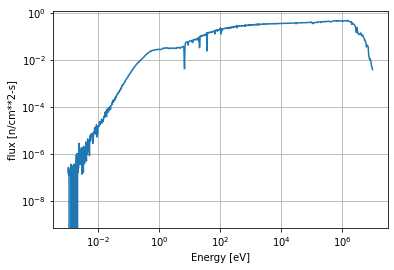

In [8]:
sp = openmc.StatePoint('statepoint.200.h5')
sp.tallies

flux_t = sp.get_tally(name='flux')
flux_df = flux_t.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm**2-s]')

Text(0, 0.5, 'flux [n/cm^2-s]')

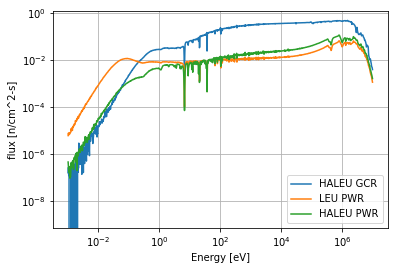

In [9]:
sp_lpwr = openmc.StatePoint('../leu_pwr/statepoint.200.h5')
flux_lpwr = sp_lpwr.get_tally(name='flux')
flux_lpwr_df = flux_lpwr.get_pandas_dataframe()
flux_lpwr_vals = flux_lpwr_df['mean'].to_numpy()

sp_hpwr = openmc.StatePoint('../haleu_pwr/statepoint.200.h5')
flux_hpwr = sp_hpwr.get_tally(name='flux')
flux_hpwr_df = flux_hpwr.get_pandas_dataframe()
flux_hpwr_vals = flux_hpwr_df['mean'].to_numpy()

plt.loglog(energy_x,flux_vals,label='HALEU GCR')
plt.loglog(energy_x,flux_lpwr_vals,label='LEU PWR')
plt.loglog(energy_x,flux_hpwr_vals,label='HALEU PWR')
plt.legend()
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm^2-s]')